In [0]:
%pip install xgboost


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# Move Maindata_cleaned-1.csv
dbutils.fs.cp(
    "dbfs:/FileStore/shared_uploads/vpasupu2@gmu.edu/Maindata_cleaned-1.csv",
    "dbfs:/FileStore/tables/Maindata_cleaned.csv"
)

# Move Housing_Sales_Data-1.csv
dbutils.fs.cp(
    "dbfs:/FileStore/shared_uploads/vpasupu2@gmu.edu/Housing_Sales_Data-1.csv",
    "dbfs:/FileStore/tables/Housing_Sales_Data.csv"
)

# Move Schoolsdata_cleaned-1.csv
dbutils.fs.cp(
    "dbfs:/FileStore/shared_uploads/vpasupu2@gmu.edu/Schoolsdata_cleaned-1.csv",
    "dbfs:/FileStore/tables/Schoolsdata_cleaned.csv"
)




Out[12]: True

In [0]:
# 1. Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# 2. Load CSVs with Spark
df_main_spark = spark.read.option("header", True).option("inferSchema", True).csv("dbfs:/FileStore/shared_uploads/vpasupu2@gmu.edu/Maindata_cleaned-1.csv")
df_housing_spark = spark.read.option("header", True).option("inferSchema", True).csv("dbfs:/FileStore/shared_uploads/vpasupu2@gmu.edu/Housing_Sales_Data-1.csv")
df_schools_spark = spark.read.option("header", True).option("inferSchema", True).csv("dbfs:/FileStore/shared_uploads/vpasupu2@gmu.edu/Schoolsdata_cleaned-1.csv")

# 3. Convert to Pandas
main_data = df_main_spark.toPandas()
housing_data = df_housing_spark.toPandas()
schools_data = df_schools_spark.toPandas()

# 4. Clean column names
main_data.columns = main_data.columns.str.strip()
housing_data.columns = housing_data.columns.str.strip()
schools_data.columns = schools_data.columns.str.strip()

# 5. Rename and clean
if "Open Year" in schools_data.columns:
    schools_data = schools_data.rename(columns={"Open Year": "List Year"})
for df in [main_data, housing_data, schools_data]:
    df["Town"] = df["Town"].str.strip()
    df["List Year"] = df["List Year"].astype(str)

# 6. Merge datasets
df = main_data.merge(housing_data, on=["Town", "List Year"], how="left", suffixes=("_main", "_house"))
df = df.merge(schools_data, on=["Town", "List Year"], how="left")
df = df.dropna(subset=["Sale Amount_main"])

# 7. Model evaluation function
def run_models(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    return [
        [label, "Random Forest", round(r2_score(y_test, y_pred_rf), 4), round(mean_squared_error(y_test, y_pred_rf, squared=False), 2)],
        [label, "XGBoost", round(r2_score(y_test, y_pred_xgb), 4), round(mean_squared_error(y_test, y_pred_xgb, squared=False), 2)]
    ]

# 8. Run models for each research question
results = []

# RQ1: Geographic factors (valuation & ratio)
geo_features = ["Assessed value_main", "Sale Ratio_main"]
df_geo = df.dropna(subset=geo_features)
results += run_models(df_geo[geo_features], df_geo["Sale Amount_main"], "Geographic Factors")

# RQ2: Educational access (school grades)
school_cols = [
    "PreKindergarten", "Kindergarten", "Grade 1", "Grade 2", "Grade 3", "Grade 4", "Grade 5",
    "Grade 6", "Grade 7", "Grade 8", "Grade 9", "Grade 10", "Grade 11", "Grade 12"
]
df_demo = df.dropna(subset=school_cols)
results += run_models(df_demo[school_cols], df_demo["Sale Amount_main"], "Educational Access")







In [0]:
# -----------------------------
# RQ3: Assessed Value + Year Sold
# -----------------------------
if "Year Sold" in main_data.columns:
    # Ensure Year Sold is numeric
    df["Year Sold"] = pd.to_numeric(df["Year Sold"], errors='coerce')
    
    features_time = ["Assessed value_main", "Year Sold"]
    df_time = df.dropna(subset=features_time + ["Sale Amount_main"])

    Xt = df_time[features_time]
    yt = df_time["Sale Amount_main"]

    # Train/Test Split
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import r2_score, mean_squared_error
    import xgboost as xgb

    Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)

    # Random Forest
    model_rf = RandomForestRegressor(random_state=42)
    model_rf.fit(Xt_train, yt_train)
    yt_pred_rf = model_rf.predict(Xt_test)

    # XGBoost
    model_xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    model_xgb.fit(Xt_train, yt_train)
    yt_pred_xgb = model_xgb.predict(Xt_test)

    results += [
        ["Valuation + Year Sold", "Random Forest", round(r2_score(yt_test, yt_pred_rf), 4), round(mean_squared_error(yt_test, yt_pred_rf, squared=False), 2)],
        ["Valuation + Year Sold", "XGBoost", round(r2_score(yt_test, yt_pred_xgb), 4), round(mean_squared_error(yt_test, yt_pred_xgb, squared=False), 2)]
    ]
else:
    results += [
        ["Valuation + Year Sold", "Random Forest", "N/A", "N/A"],
        ["Valuation + Year Sold", "XGBoost", "N/A", "N/A"]
    ]


In [0]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Research Focus", "Model", "R2 Score", "RMSE"])

# Force all values to string to avoid type inference issues in Azure
results_df["R2 Score"] = results_df["R2 Score"].astype(str)
results_df["RMSE"] = results_df["RMSE"].astype(str)

# Display
display(results_df)


Research Focus,Model,R2 Score,RMSE
Geographic Factors,Random Forest,0.9543,588833.05
Geographic Factors,XGBoost,0.6889,1537147.15
Educational Access,Random Forest,0.0034,6142243.34
Educational Access,XGBoost,0.0034,6142310.58
Valuation + Year Sold,Random Forest,0.0821,2640336.49
Valuation + Year Sold,XGBoost,0.0821,2640370.78


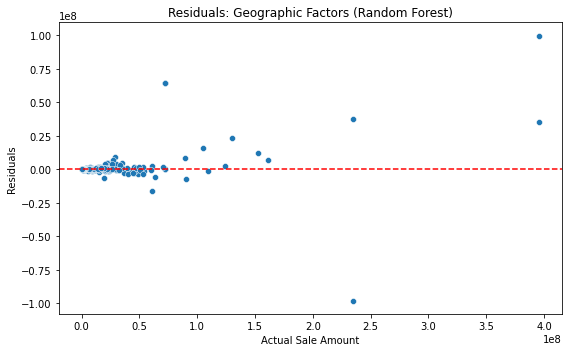

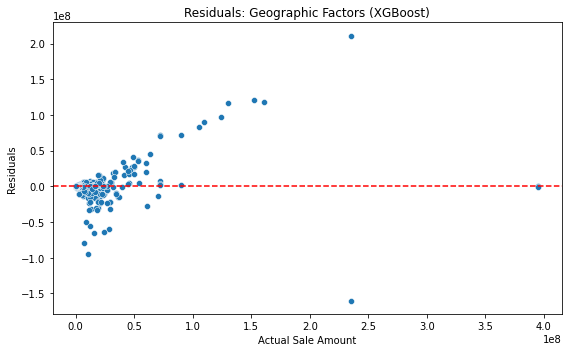

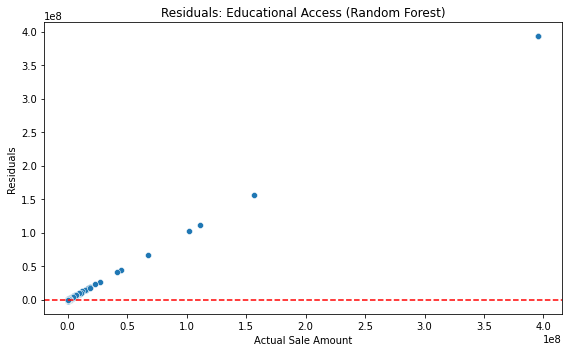

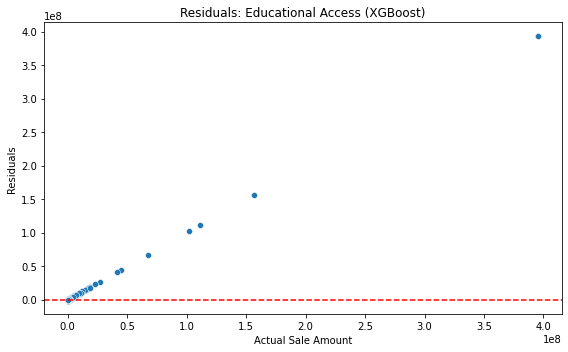

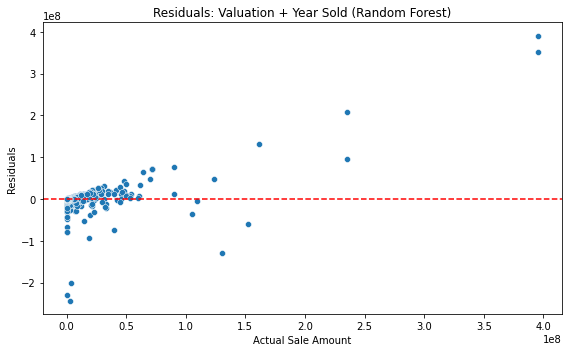

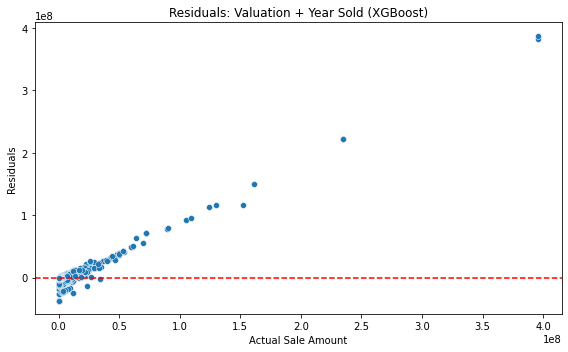

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Year Sold' is numeric
df["Year Sold"] = pd.to_numeric(df["Year Sold"], errors='coerce')

# ------------------ Utility Function ------------------
def plot_residuals(model, X_test, y_test, title):
    residuals = y_test - model.predict(X_test)
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=y_test, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Actual Sale Amount')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ------------------ RQ1: Geographic Factors ------------------
geo_features = ["Assessed value_main", "Sale Ratio_main"]
df_geo = df.dropna(subset=geo_features + ["Sale Amount_main"])
Xg = df_geo[geo_features]
yg = df_geo["Sale Amount_main"]
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, yg, test_size=0.2, random_state=42)

# Train models
rf_geo = RandomForestRegressor(random_state=42).fit(Xg_train, yg_train)
xgb_geo = xgb.XGBRegressor(objective="reg:squarederror", random_state=42).fit(Xg_train, yg_train)

# Plot residuals
plot_residuals(rf_geo, Xg_test, yg_test, "Residuals: Geographic Factors (Random Forest)")
plot_residuals(xgb_geo, Xg_test, yg_test, "Residuals: Geographic Factors (XGBoost)")

# ------------------ RQ2: Educational Access ------------------
school_cols = [
    "PreKindergarten", "Kindergarten", "Grade 1", "Grade 2", "Grade 3", "Grade 4", "Grade 5",
    "Grade 6", "Grade 7", "Grade 8", "Grade 9", "Grade 10", "Grade 11", "Grade 12"
]
df_edu = df.dropna(subset=school_cols + ["Sale Amount_main"])
Xe = df_edu[school_cols]
ye = df_edu["Sale Amount_main"]
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye, test_size=0.2, random_state=42)

# Train models
rf_edu = RandomForestRegressor(random_state=42).fit(Xe_train, ye_train)
xgb_edu = xgb.XGBRegressor(objective="reg:squarederror", random_state=42).fit(Xe_train, ye_train)

# Plot residuals
plot_residuals(rf_edu, Xe_test, ye_test, "Residuals: Educational Access (Random Forest)")
plot_residuals(xgb_edu, Xe_test, ye_test, "Residuals: Educational Access (XGBoost)")

# ------------------ RQ3: Valuation + Year Sold ------------------
time_features = ["Assessed value_main", "Year Sold"]
df_time = df.dropna(subset=time_features + ["Sale Amount_main"])
Xt = df_time[time_features]
yt = df_time["Sale Amount_main"]
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)

# Train models
rf_time = RandomForestRegressor(random_state=42).fit(Xt_train, yt_train)
xgb_time = xgb.XGBRegressor(objective="reg:squarederror", random_state=42).fit(Xt_train, yt_train)

# Plot residuals
plot_residuals(rf_time, Xt_test, yt_test, "Residuals: Valuation + Year Sold (Random Forest)")
plot_residuals(xgb_time, Xt_test, yt_test, "Residuals: Valuation + Year Sold (XGBoost)")


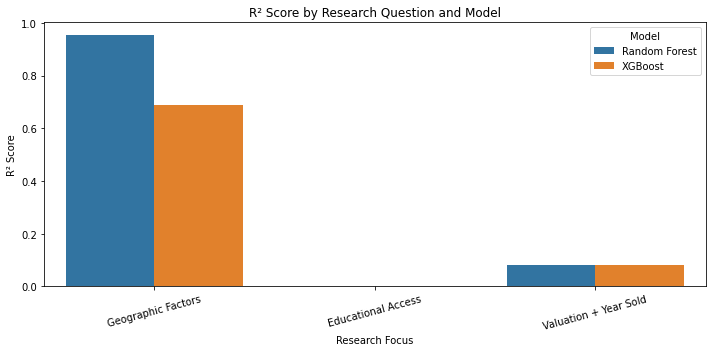

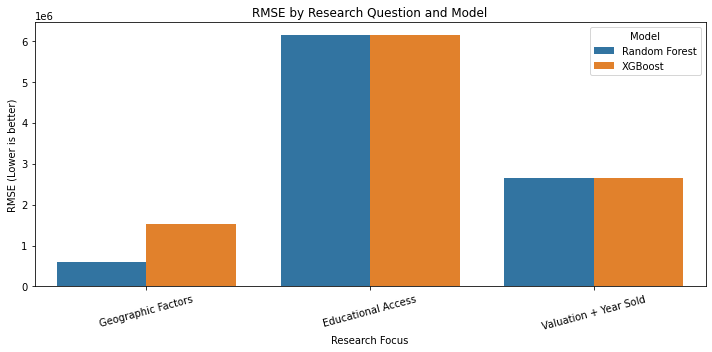

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the results manually based on the user's screenshot
results_df = pd.DataFrame({
    "Research Focus": [
        "Geographic Factors", "Geographic Factors",
        "Educational Access", "Educational Access",
        "Valuation + Year Sold", "Valuation + Year Sold"
    ],
    "Model": [
        "Random Forest", "XGBoost",
        "Random Forest", "XGBoost",
        "Random Forest", "XGBoost"
    ],
    "R2 Score": [0.9543, 0.6889, 0.0034, 0.0034, 0.0821, 0.0821],
    "RMSE": [588833.05, 1537147.15, 6142243.34, 6142310.58, 2640336.49, 2640370.78]
})

# Plot R2 Scores
plt.figure(figsize=(10, 5))
sns.barplot(x="Research Focus", y="R2 Score", hue="Model", data=results_df)
plt.title("R² Score by Research Question and Model")
plt.ylabel("R² Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 5))
sns.barplot(x="Research Focus", y="RMSE", hue="Model", data=results_df)
plt.title("RMSE by Research Question and Model")
plt.ylabel("RMSE (Lower is better)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
